<a href="https://colab.research.google.com/github/ytwang3579/TextMining/blob/master/Information_Retrieval_Homework_Group4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#- Information Retrieval - Vector Space Model- Homework sample code 

In [1]:
#Mount google drive to google colab virtual machine
from google.colab import drive
drive.mount('/content/drive')
mydrive ="/content/drive/My Drive/Colab Notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 1: connect to google drive , Read all document from google drive**
**you need to upload the data to your google drive with correct path**


In [2]:
# this code will read all file in "movies_synopsis" folder, use nltk to tokenize and convert to lower()case
import nltk,os
nltk.download('punkt')
file_path = mydrive +"movies_synopsis/"
doc_all={}

for filename in os.listdir(file_path ):
  fileExtension = filename.split(".")[-1]
  if fileExtension == "txt": # just read .txt file, in case google drive insert some hidden file which make the error.
    text = open(file_path+filename).read()
    tokens = nltk.word_tokenize(text)
    token_filtered = [w.lower() for w in tokens if w.isalpha()]
    doc_all[filename[:-4]]=token_filtered

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Step2: convert all document to vector, use tfidf weighting**

In [0]:
# Declare all function 
# create tf function
def tf(term, token_doc):
    tf = token_doc.count(term)/len(token_doc)
    return tf

# create function to calculate how many doc contain the term 
def numDocsContaining(word, token_doclist):
    doccount = 0
    for doc_token in token_doclist:
        if doc_token.count(word) > 0:
            doccount +=1
    return doccount
  
import math
# create function to calculate  Inverse Document Frequency in doclist - this list of all documents
def idf(word, token_doclist):
    n = len(token_doclist)
    df = numDocsContaining(word, token_doclist)
    return math.log10(n/df)

#define a function to do cosine normalization a data dictionary
def cos_norm(dic): # dic is distionary data structure
  import numpy as np
  dic_norm={}
  factor=1.0/np.sqrt(sum([np.square(i) for i in dic.values()]))
  for k in dic:
    dic_norm[k] = dic[k]*factor
  return dic_norm

#create function to calculate normalize tfidf 
def compute_tfidf(token_doc,bag_words_idf):
  tfidf_doc={}
  for word in set(token_doc):
    tfidf_doc[word]= tf(word,token_doc) * bag_words_idf[word]   
  tfidf_norm = cos_norm(tfidf_doc)
  return tfidf_norm

# create normalize term frequency
def tf_norm(token_doc):
  tf_norm={}
  for term in token_doc:
    tf = token_doc.count(term)/len(token_doc)
    tf_norm[term]=tf
  tf_max = max(tf_norm.values())
  for term, value in tf_norm.items():
    tf_norm[term]= 0.5 + 0.5*value/tf_max
  return tf_norm

def compute_tfidf_query(query_token,bag_words_idf):
  tfidf_query={}
  tf_norm_query = tf_norm(query_token)
  for term, value in tf_norm_query.items():
    tfidf_query[term]=value*bag_words_idf[term]   
  return tfidf_query

In [4]:
import os
from datetime import datetime
from pytz import timezone
now = datetime.now(timezone('Asia/Taipei'))
start_time = now.strftime("%H:%M:%S")
print("Start tfidf processing at", start_time)

#create bag words
bag_words =[] # declare bag_words is a list
for doc in doc_all.keys():
  bag_words += doc_all[doc]

bag_words=set(bag_words)

#calculate idf for every word in bag_words
bag_words_idf={} # declare "bag_words_idf" data structure is dictionary 
bag_words_len = len(bag_words)
bag_word_10 = round(bag_words_len/10,0)
print("the number of term in bag_word", bag_words_len)
print("Start idf processing")
i=0
for word in bag_words:
  i+=1
  if (i%bag_word_10==0):print("finish %s idf processing" %(str(round(i*10/bag_word_10))+"%"))
  bag_words_idf[word]= idf(word,doc_all.values())

print("finish idf processing")
##calculate tfidf with cosine normalization
tfidf={} # declare tfidf dictionary to store tfidf value
for doc in doc_all.keys():
  tfidf[doc]= compute_tfidf(doc_all[doc],bag_words_idf)
finish_time = datetime.now(timezone('Asia/Taipei')).strftime("%H:%M:%S")
print("finish tfidf processing at", finish_time)

Start tfidf processing at 22:08:01
the number of term in bag_word 23883
Start idf processing
finish 10% idf processing
finish 20% idf processing
finish 30% idf processing
finish 40% idf processing
finish 50% idf processing
finish 60% idf processing
finish 70% idf processing
finish 80% idf processing
finish 90% idf processing
finish 100% idf processing
finish idf processing
finish tfidf processing at 22:11:24


**Step3: Input query text, and take similarity, if you change the query text, just need to  run the code again from here** 

In [5]:
query="science fiction movies about dreams, reality and virtual world"
query_token_raw= nltk.word_tokenize(query)
query_token = [term for term in query_token_raw if term in bag_words]

tfidf_query =compute_tfidf_query(query_token,bag_words_idf) #calculate tfidf for query text
print(tfidf_query)

{'science': 1.4965837344890947, 'fiction': 2.098643725817057, 'movies': 1.9225524667613758, 'about': 0.11864035423331064, 'dreams': 1.098643725817057, 'reality': 1.0017337128090005, 'and': 0.026761718510931582, 'virtual': 2.399673721481038, 'world': 0.4454312120417132}


In [6]:
# add tfidf of query text to tfidf of all doc and convert to dataframe
tfidf["query"]=tfidf_query

import pandas as pd
tfidf_df = pd.DataFrame(tfidf).transpose()
tfidf_df= tfidf_df.fillna(0) # replace all NaN by zero

from scipy.spatial.distance import cosine
cosine_sim ={}
for row in tfidf_df.index:
  if row != "query":
    cosine_sim[row]= 1-cosine(tfidf_df.loc[row],tfidf_df.loc["query"])

# the top 10 relevant document
cosine_sim_top10 = dict(sorted(cosine_sim.items(), key=lambda item: item[1],reverse=True)[:10])
print(cosine_sim_top10)

{'Inception (2010)': 0.01788571590120236, 'Alien (1979)': 0.011192516029991051, 'The Great Dictator (1940)': 0.009719218506647032, 'Requiem for a Dream (2000)': 0.009304619078016274, 'Reservoir Dogs (1992)': 0.009123815908107957, 'The Matrix (1999)': 0.006354878507958683, 'A Beautiful Mind (2001)': 0.006154701176799615, 'It_s a Wonderful Life (1946)': 0.006020772511826533, '12 Angry Men (1957)': 0.005822391379437075, 'Interstellar (2014)': 0.0053728162352094655}


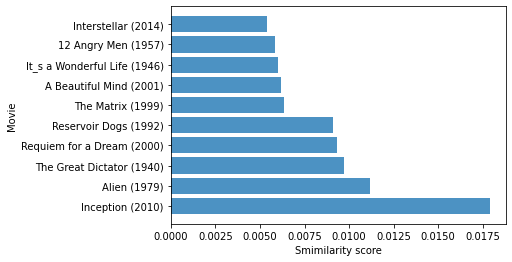

In [7]:
#plot barchart
import matplotlib.pyplot as plt
data = cosine_sim_top10
plt.barh(range(len(data)), list(data.values()), align='center', alpha=0.8)
plt.yticks(range(len(data)), list(data.keys())) # label for y axis
plt.xlabel('Smimilarity score')
plt.ylabel('Movie')

# save graph
plt.savefig(mydrive+"barchart.png", bbox_inches='tight', dpi=600)
plt.show()

In [8]:
# this code will read all file in "movies_synopsis" folder, use nltk to tokenize and convert to lower()case
import nltk,os
nltk.download('punkt')
file_path = mydrive +"movies_synopsis/"
doc_all={}

for filename in os.listdir(file_path ):
  fileExtension = filename.split(".")[-1]
  if fileExtension == "txt": # just read .txt file, in case google drive insert some hidden file which make the error.
    text = open(file_path+filename).read()
    tokens = nltk.word_tokenize(text)
    token_filtered = [w.lower() for w in tokens if w.isalpha()]
    doc_all[filename[:-4]]=token_filtered

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
nltk.download('stopwords')
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

pos_bag_words =[] # declare bag_words is a list
for doc in doc_all.keys():
  from nltk.corpus import stopwords
  stopwords = set(stopwords.words('english'))

  doc_all[doc] = [word for word in doc_all[doc] if not word in stopwords]



  doc_all[doc] = nltk.pos_tag(doc_all[doc], tagset='universal')
  fs = ['NOUN']
  doc_all[doc] = [word for word in doc_all[doc] if word[1] in fs]
  
  pos_bag_words_lem = []
  for word, tag in doc_all[doc]:
    lemmatag = tag[0].lower()
    lemmatag = lemmatag if lemmatag in ['n', 'v', 'a'] else None
    if not lemmatag:
      pos_bag_words_lem.append(wnl.lemmatize(word))
    else:
      pos_bag_words_lem.append(wnl.lemmatize(word, lemmatag))
  
  doc_all[doc] = pos_bag_words_lem

  pos_bag_words += doc_all[doc]

print(pos_bag_words)
pos_bag_words=set(pos_bag_words)
print(len(pos_bag_words))

filtered_pos_bag_words = []
for word in pos_bag_words:
  if numDocsContaining(word,doc_all.values()) != 1:
    filtered_pos_bag_words.append(word)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['york', 'city', 'courthouse', 'boy', 'slum', 'trial', 'death', 'closing', 'argument', 'judge', 'instructs', 'jury', 'boy', 'murder', 'doubt', 'return', 'verdict', 'judge', 'informs', 'verdict', 'death', 'sentence', 'jury', 'room', 'juror', 'begin', 'juror', 'boy', 'plan', 'verdict', 'time', 'discussion', 'exception', 'juror', 'henry', 'fonda', 'vote', 'stake', 'vote', 'juror', 'jack', 'ticket', 'baseball', 'game', 'juror', 'ed', 'begley', '

In [10]:
for doc in doc_all.keys():
  doc_all[doc] = [word for word in doc_all[doc] if word in filtered_pos_bag_words]
len(filtered_pos_bag_words)

5994

In [11]:
import os
from datetime import datetime
from pytz import timezone
now = datetime.now(timezone('Asia/Taipei'))
start_time = now.strftime("%H:%M:%S")
print("Start tfidf processing at", start_time)

pos_bag_words = set(filtered_pos_bag_words)
print(pos_bag_words)

#calculate idf for every word in bag_words
pos_bag_words_idf={} # declare "bag_words_idf" data structure is dictionary 
pos_bag_words_len = len(pos_bag_words)
pos_bag_word_10 = round(pos_bag_words_len/10,0)
print("the number of term in pos_bag_word", pos_bag_words_len)
print("Start idf processing")
i=0
for word in pos_bag_words:
  i+=1
  if (i%pos_bag_word_10==0):print("finish %s idf processing" %(str(round(i*10/pos_bag_word_10))+"%"))
  pos_bag_words_idf[word]= idf(word,doc_all.values())

print("finish idf processing")
##calculate tfidf with cosine normalization
tfidf={} # declare tfidf dictionary to store tfidf value
for doc in doc_all.keys():
    tfidf[doc]= compute_tfidf(doc_all[doc],pos_bag_words_idf)
finish_time = datetime.now(timezone('Asia/Taipei')).strftime("%H:%M:%S")
print("finish tfidf processing at", finish_time)

Start tfidf processing at 22:12:42
{'aamir', 'cape', 'sonny', 'sick', 'minimum', 'governor', 'talia', 'freed', 'board', 'surgery', 'lamb', 'martha', 'eulogy', 'id', 'hesitate', 'breathe', 'grenade', 'sherman', 'savior', 'glider', 'fellow', 'compensation', 'syndrome', 'editor', 'cheek', 'breast', 'cameo', 'punishment', 'yield', 'gear', 'awakens', 'skynet', 'expert', 'caption', 'drone', 'sleep', 'faint', 'dancing', 'cent', 'prove', 'cohen', 'sunk', 'seagull', 'winter', 'nurse', 'timer', 'tense', 'windshield', 'barn', 'employer', 'france', 'lee', 'sociopath', 'sunrise', 'examines', 'tender', 'summit', 'affleck', 'popularity', 'dennis', 'recovery', 'contribution', 'slyly', 'riding', 'paperwork', 'hallucination', 'confusion', 'byrne', 'gadget', 'code', 'staircase', 'reef', 'past', 'administration', 'cattle', 'rio', 'initiate', 'commit', 'pitch', 'genuine', 'describe', 'castration', 'host', 'brutality', 'support', 'foundry', 'listens', 'loan', 'retaliates', 'ingenuity', 'proceed', 'back', 's

In [12]:
query="science fiction movies about dreams, reality and virtual world"
query= nltk.word_tokenize(query)
print(query)
query_token_raw = []
for word in query:
  query_token_raw.append(wnl.lemmatize(word))
pos_query_token = [term for term in query_token_raw if term in pos_bag_words]

pos_tfidf_query =compute_tfidf_query(pos_query_token,pos_bag_words_idf) #calculate tfidf for query text
print(pos_tfidf_query)

['science', 'fiction', 'movies', 'about', 'dreams', ',', 'reality', 'and', 'virtual', 'world']
{'science': 1.3996737214810382, 'fiction': 2.098643725817057, 'movie': 0.5484153727619628, 'dream': 0.8314719974140432, 'reality': 0.9683099573220508, 'world': 0.4454312120417132}


In [13]:
# add tfidf of query text to tfidf of all doc and convert to dataframe
tfidf["query"]=pos_tfidf_query

import pandas as pd
tfidf_df = pd.DataFrame(tfidf).transpose()
tfidf_df= tfidf_df.fillna(0) # replace all NaN by zero

from scipy.spatial.distance import cosine
cosine_sim ={}
for row in tfidf_df.index:
  if row != "query":
    cosine_sim[row]= 1-cosine(tfidf_df.loc[row],tfidf_df.loc["query"])

# the top 10 relevant document
cosine_sim_top10 = dict(sorted(cosine_sim.items(), key=lambda item: item[1],reverse=True)[:10])
print(cosine_sim_top10)

{'Inception (2010)': 0.07657658869190986, 'Taare Zameen Par (2007)': 0.05369218883406146, 'The Matrix (1999)': 0.04143589239603451, 'The Great Dictator (1940)': 0.03130957791142219, 'In the Mood for Love (2000)': 0.028655884000587384, 'Wild Strawberries (1957)': 0.02721436155195678, 'Inside Out (I) (2015)': 0.025860512674811598, 'Your Name. (2016)': 0.024471634347301707, 'The Silence of the Lambs (1991)': 0.02373114729859893, 'Sherlock Jr. (1924)': 0.022538123138663435}


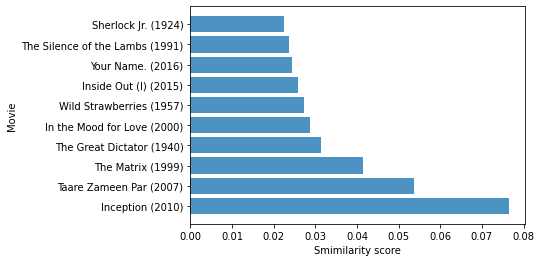

In [14]:
import matplotlib.pyplot as plt
#plot barchart
data = cosine_sim_top10
plt.barh(range(len(data)), list(data.values()), align='center', alpha=0.8)
plt.yticks(range(len(data)), list(data.keys())) # label for y axis
plt.xlabel('Smimilarity score')
plt.ylabel('Movie')

# save graph
plt.savefig(mydrive+"barchart.png", bbox_inches='tight', dpi=600)
plt.show()